# Shoplifting Detection- Baseline

This notebook implements a video-based shoplifting detection system using ResNet50 for feature extraction and GRU for sequence modeling.

---

## 1. Google Colab Setup and Imports

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import zipfile
import pickle
import random
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
import tensorflow as tf
import keras
from keras.layers import (GlobalAveragePooling2D, Input, Add, Dense,
                         Activation, ZeroPadding2D, Flatten, Conv2D,
                         AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,
                         Dropout, BatchNormalization, Lambda, GRU)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.19.0
Keras version: 3.10.0


In [5]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [6]:
# GPU configuration for Colab
try:
    # Enable GPU if available
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("✅ GPU found and configured")
        print(f"GPU: {tf.test.gpu_device_name()}")
    else:
        print("⚠️  No GPU found, using CPU")
except:
    print("⚠️  Using CPU")

✅ GPU found and configured
GPU: /device:GPU:0


In [7]:
# Check available RAM
import psutil
ram_gb = psutil.virtual_memory().total / (1024**3)
print(f"💾 Available RAM: {ram_gb:.1f} GB")

💾 Available RAM: 12.7 GB


---

## 2. Google Drive Paths and Configuration

In [8]:
# Google Drive paths configuration
DRIVE_BASE = "/content/drive/MyDrive"
DATASETS_DIR = os.path.join(DRIVE_BASE, "Datasets")
EXTRACTED_DIR = os.path.join(DATASETS_DIR, "Extracted Data")

In [9]:
# Create directories if they don't exist
os.makedirs(DATASETS_DIR, exist_ok=True)
os.makedirs(EXTRACTED_DIR, exist_ok=True)

In [10]:
# Your dataset zip file path (UPDATE THIS!)
DATASET_ZIP_PATH = os.path.join(DATASETS_DIR, "Shop DataSet.zip")  # Change this to your zip file name

In [11]:
# Extracted dataset paths
DATASET_NAME = "Shop DataSet"  # Name of your dataset folder after extraction
DATASET_PATH = os.path.join(EXTRACTED_DIR, DATASET_NAME)

In [12]:
# Model configuration - Optimized for Colab
IMG_SIZE = 224
BATCH_SIZE = 16  # Reduced for Colab memory limits
EPOCHS = 50      # Reduced for faster training in Colab
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048
FEATURE_BATCH_SIZE = 8  # Small batches for feature extraction to avoid memory issues

print(f"📁 Google Drive base: {DRIVE_BASE}")
print(f"📁 Datasets directory: {DATASETS_DIR}")
print(f"📁 Dataset will be extracted to: {DATASET_PATH}")
print(f"📁 Looking for zip file at: {DATASET_ZIP_PATH}")

📁 Google Drive base: /content/drive/MyDrive
📁 Datasets directory: /content/drive/MyDrive/Datasets
📁 Dataset will be extracted to: /content/drive/MyDrive/Datasets/Extracted Data/Shop DataSet
📁 Looking for zip file at: /content/drive/MyDrive/Datasets/Shop DataSet.zip


In [13]:
# Check if Google Drive is mounted
if os.path.exists(DRIVE_BASE):
    print("✅ Google Drive mounted successfully")
else:
    print("❌ Google Drive not mounted. Please run drive.mount() first.")

✅ Google Drive mounted successfully


---

## 3. Data Extraction and Setup

In [14]:
def extract_dataset_from_drive(zip_path, extract_to):
    """Extract dataset from Google Drive zip file"""
    if not os.path.exists(zip_path):
        print(f"❌ Zip file not found at: {zip_path}")
        print("\n📋 To upload your dataset:")
        print("1. Go to Google Drive")
        print("2. Navigate to MyDrive/Datasets/")
        print("3. Upload your dataset zip file")
        print("4. Update DATASET_ZIP_PATH variable with the correct filename")
        return False

    print(f"📦 Extracting dataset from: {zip_path}")

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # List contents first
            file_list = zip_ref.namelist()
            print(f"📄 Found {len(file_list)} files in zip")

            # Extract all files
            zip_ref.extractall(extract_to)
            print(f"✅ Dataset extracted to: {extract_to}")
            return True
    except Exception as e:
        print(f"❌ Error extracting dataset: {e}")
        return False

In [15]:
def setup_dataset_structure():
    """Setup and validate dataset structure"""

    # Check if already extracted
    if os.path.exists(DATASET_PATH):
        print(f"✅ Dataset already extracted at: {DATASET_PATH}")
    else:
        # Try to extract
        if not extract_dataset_from_drive(DATASET_ZIP_PATH, EXTRACTED_DIR):
            return False

    # Validate structure
    if not os.path.exists(DATASET_PATH):
        print(f"❌ Dataset folder not found: {DATASET_PATH}")
        print("Please check your zip file structure. Expected folder name: 'Shop DataSet'")
        return False

    # Check dataset categories
    try:
        label_types = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
        print(f"📊 Found categories: {label_types}")

        total_videos = 0
        for category in label_types:
            category_path = os.path.join(DATASET_PATH, category)
            videos = [f for f in os.listdir(category_path) if f.endswith(('.mp4', '.avi', '.mov'))]
            print(f"   {category}: {len(videos)} videos")
            total_videos += len(videos)

        print(f"📈 Total videos: {total_videos}")

        if total_videos == 0:
            print("⚠️  No video files found!")
            return False

        return True

    except Exception as e:
        print(f"❌ Error checking dataset structure: {e}")
        return False

In [16]:
# Setup dataset
print("🚀 Setting up dataset...")
dataset_ready = setup_dataset_structure()

if dataset_ready:
    print("✅ Dataset setup complete!")
else:
    print("❌ Dataset setup failed. Please check your files and try again.")

🚀 Setting up dataset...
📦 Extracting dataset from: /content/drive/MyDrive/Datasets/Shop DataSet.zip
📄 Found 857 files in zip
✅ Dataset extracted to: /content/drive/MyDrive/Datasets/Extracted Data
📊 Found categories: ['non shop lifters', 'shop lifters']
   non shop lifters: 531 videos
   shop lifters: 324 videos
📈 Total videos: 855
✅ Dataset setup complete!


---

## 4. Data Loading and Preprocessing

In [17]:
def create_dataframe():
    """Create dataframe with video paths and labels"""
    if not dataset_ready:
        print("Dataset not ready. Please check the dataset setup.")
        return None

    rooms = []
    label_types = os.listdir(DATASET_PATH)

    for item in label_types:
        category_path = os.path.join(DATASET_PATH, item)
        if os.path.isdir(category_path):
            all_videos = os.listdir(category_path)
            for video in all_videos:
                if video.endswith(('.mp4', '.avi', '.mov')):  # Video file extensions
                    video_path = os.path.join(category_path, video)
                    rooms.append((item, video_path))

    # Build dataframe
    dataSet_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
    print(f"Total videos in dataset: {len(dataSet_df)}")
    print("\nDataset sample:")
    print(dataSet_df.head())

    # Save dataframe to Google Drive
    csv_path = os.path.join(DATASETS_DIR, 'dataset.csv')
    dataSet_df.to_csv(csv_path, index=False)
    print(f"💾 Dataset info saved to: {csv_path}")

    return dataSet_df

In [18]:
def crop_center_square(frame):
    """Crop frame to center square"""
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [19]:
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    """Load video frames with error handling"""
    if not os.path.exists(path):
        print(f"Video not found: {path}")
        return np.array([])

    cap = cv2.VideoCapture(path)
    frames = []

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Preprocess frame
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]  # Convert BGR to RGB
            frames.append(frame)

            if max_frames > 0 and len(frames) == max_frames:
                break
    except Exception as e:
        print(f"Error processing video {path}: {e}")
    finally:
        cap.release()

    return np.array(frames)

In [20]:
# Create dataset dataframe
dataSet_df = create_dataframe()
if dataSet_df is not None:
    print(f"\nDataset created successfully with {len(dataSet_df)} videos")

Total videos in dataset: 855

Dataset sample:
                tag                                         video_name
0  non shop lifters  /content/drive/MyDrive/Datasets/Extracted Data...
1  non shop lifters  /content/drive/MyDrive/Datasets/Extracted Data...
2  non shop lifters  /content/drive/MyDrive/Datasets/Extracted Data...
3  non shop lifters  /content/drive/MyDrive/Datasets/Extracted Data...
4  non shop lifters  /content/drive/MyDrive/Datasets/Extracted Data...
💾 Dataset info saved to: /content/drive/MyDrive/Datasets/dataset.csv

Dataset created successfully with 855 videos


---

## 5. ResNet50 Architecture

In [21]:
def identity_block(X, f, filters, initializer=random_uniform):
    """Implementation of the identity block"""
    F1, F2, F3 = filters
    X_shortcut = X

    # First component
    X = Conv2D(filters=F1, kernel_size=1, strides=(1,1), padding='valid',
               kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same',
               kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component
    X = Conv2D(filters=F3, kernel_size=1, strides=(1,1), padding='valid',
               kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    # Add shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [22]:
def convolutional_block(X, f, filters, s=2, initializer=glorot_uniform):
    """Implementation of the convolutional block"""
    F1, F2, F3 = filters
    X_shortcut = X

    # Main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid',
               kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1, 1), padding='same',
               kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding='valid',
               kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    # Shortcut path
    X_shortcut = Conv2D(filters=F3, kernel_size=1, strides=(s, s), padding='valid',
                        kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Add shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [23]:
def ResNet50_feature_extractor(input_shape=(224, 224, 3)):
    """Custom ResNet50 for feature extraction"""
    X_input = Input(input_shape)

    # Stage 1
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # Global Average Pooling
    X = GlobalAveragePooling2D()(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name="ResNet50_feature_extractor")
    return model

In [24]:
def build_feature_extractor():
    """Build complete feature extractor with preprocessing"""
    # Build ResNet50 feature extractor
    feature_extractor = ResNet50_feature_extractor(input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Define preprocessing
    preprocess_input = keras.applications.resnet50.preprocess_input

    # Input layer
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))

    # Apply preprocessing using Lambda layer
    preprocessed = Lambda(preprocess_input)(inputs)

    # Pass to feature extractor
    outputs = feature_extractor(preprocessed)

    return keras.Model(inputs, outputs, name="feature_extractor")

In [25]:
# Build feature extractor
print("Building feature extractor...")
feature_extractor = build_feature_extractor()
print("Feature extractor built successfully!")
feature_extractor.summary()

Building feature extractor...
Feature extractor built successfully!


Model: "feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ResNet50_feature_extractor      │ (None, 2048)           │    23,587,712 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

---

## 6. Feature Extraction

In [26]:
def extract_features_colab_optimized(df, save_path, batch_size=FEATURE_BATCH_SIZE):
    """Extract features from all videos - optimized for Google Colab"""

    if os.path.exists(save_path):
        print(f"✅ Features already extracted. Loading from: {save_path}")
        try:
            with open(save_path, 'rb') as f:
                return pickle.load(f)
        except Exception as e:
            print(f"❌ Error loading saved features: {e}")
            print("🔄 Re-extracting features...")

    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values

    # Setup label processor
    label_processor = keras.layers.StringLookup(
        num_oov_indices=0,
        vocabulary=np.unique(labels)
    )
    print(f"🏷️  Label vocabulary: {label_processor.get_vocabulary()}")

    # Convert labels
    encoded_labels = label_processor(labels[..., None]).numpy()

    # Initialize arrays
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    print(f"🎬 Processing {num_samples} videos...")
    print("💡 Tip: This may take a while. Colab will show processing progress.")

    # Process videos with progress tracking
    successful_videos = 0
    failed_videos = 0

    for idx, path in enumerate(video_paths):
        print(f"\r🎯 Processing video {idx+1}/{num_samples}: {os.path.basename(path)[:50]}...", end="", flush=True)

        try:
            # Load video frames
            frames = load_video(path)

            if len(frames) == 0:
                print(f"\n⚠️  Warning: No frames loaded from {os.path.basename(path)}")
                failed_videos += 1
                continue

            video_length = len(frames)

            # Set up mask
            length = min(MAX_SEQ_LENGTH, video_length)
            frame_masks[idx, :length] = 1

            # Process frames in small batches to avoid memory issues
            processed_features = []

            for start in range(0, video_length, batch_size):
                end = min(start + batch_size, video_length)
                batch = frames[start:end]

                # Extract features for this batch
                try:
                    batch_features = feature_extractor.predict(batch, verbose=0)
                    processed_features.append(batch_features)
                except Exception as e:
                    print(f"\n❌ Error processing batch for {os.path.basename(path)}: {e}")
                    break

                # Clear memory
                del batch
                if idx % 10 == 0:  # Periodic garbage collection
                    gc.collect()

            if processed_features:
                # Concatenate all features
                all_features = np.concatenate(processed_features, axis=0)

                # Store features (only up to MAX_SEQ_LENGTH)
                features_to_store = min(len(all_features), MAX_SEQ_LENGTH)
                frame_features[idx, :features_to_store, :] = all_features[:features_to_store]
                successful_videos += 1

            # Clear memory
            del frames, processed_features
            if 'all_features' in locals():
                del all_features

            # Force garbage collection every few videos
            if idx % 5 == 0:
                gc.collect()

        except Exception as e:
            print(f"\n❌ Error processing {os.path.basename(path)}: {e}")
            failed_videos += 1
            continue

    print(f"\n✅ Feature extraction complete!")
    print(f"   Successful: {successful_videos} videos")
    print(f"   Failed: {failed_videos} videos")

    # Save results to Google Drive
    result = {
        'frame_features': frame_features,
        'frame_masks': frame_masks,
        'labels': encoded_labels,
        'label_processor': label_processor,
        'successful_videos': successful_videos,
        'total_videos': num_samples
    }

    try:
        with open(save_path, 'wb') as f:
            pickle.dump(result, f)
        print(f"💾 Features saved to Google Drive: {save_path}")
    except Exception as e:
        print(f"❌ Error saving features: {e}")
        # Try saving to local Colab storage as backup
        backup_path = "/content/extracted_features_backup.pkl"
        with open(backup_path, 'wb') as f:
            pickle.dump(result, f)
        print(f"💾 Backup saved to: {backup_path}")

    return result

In [27]:
# Extract features
if dataSet_df is not None and dataset_ready:
    features_path = os.path.join(DATASETS_DIR, 'extracted_features.pkl')

    print("🚀 Starting feature extraction...")
    print("⏱️  This process may take 10-30 minutes depending on your dataset size")

    feature_data = extract_features_colab_optimized(dataSet_df, features_path)

    print(f"\n📊 FEATURE EXTRACTION RESULTS:")
    print(f"   Frame features shape: {feature_data['frame_features'].shape}")
    print(f"   Frame masks shape: {feature_data['frame_masks'].shape}")
    print(f"   Labels shape: {feature_data['labels'].shape}")
    print(f"   Success rate: {feature_data['successful_videos']}/{feature_data['total_videos']} videos")

else:
    print("⚠️  Skipping feature extraction - dataset not ready")

🚀 Starting feature extraction...
⏱️  This process may take 10-30 minutes depending on your dataset size
🏷️  Label vocabulary: [np.str_('non shop lifters'), np.str_('shop lifters')]
🎬 Processing 855 videos...
💡 Tip: This may take a while. Colab will show processing progress.
🎯 Processing video 855/855: videyyyyyyzzzzzyyyss_9.mp4...
✅ Feature extraction complete!
   Successful: 855 videos
   Failed: 0 videos
💾 Features saved to Google Drive: /content/drive/MyDrive/Datasets/extracted_features.pkl

📊 FEATURE EXTRACTION RESULTS:
   Frame features shape: (855, 20, 2048)
   Frame masks shape: (855, 20)
   Labels shape: (855, 1)
   Success rate: 855/855 videos


---

## 7. Data Preparation and Normalization

In [28]:
def prepare_data(feature_data, test_size=0.2, random_state=42):
    """Prepare and normalize data for training"""

    frame_features = feature_data['frame_features']
    frame_masks = feature_data['frame_masks']
    labels = feature_data['labels']

    print("Original data shapes:")
    print(f"  Frame features: {frame_features.shape}")
    print(f"  Frame masks: {frame_masks.shape}")
    print(f"  Labels: {labels.shape}")

    # Split data
    (X_train_features, X_test_features,
     X_train_masks, X_test_masks,
     y_train, y_test) = train_test_split(
        frame_features, frame_masks, labels,
        test_size=test_size, random_state=random_state, stratify=labels
    )

    print(f"\nAfter train-test split:")
    print(f"  Training samples: {len(X_train_features)}")
    print(f"  Test samples: {len(X_test_features)}")

    # Normalize features
    print("Normalizing features...")

    # Get shapes
    train_n_samples, train_max_length, train_n_features = X_train_features.shape
    test_n_samples, test_max_length, test_n_features = X_test_features.shape

    # Reshape to 2D for normalization
    train_features_flat = X_train_features.reshape(-1, train_n_features)
    test_features_flat = X_test_features.reshape(-1, test_n_features)

    # Apply Min-Max scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_features_normalized = scaler.fit_transform(train_features_flat)
    test_features_normalized = scaler.transform(test_features_flat)  # Use transform, not fit_transform

    # Reshape back to 3D
    X_train_features = train_features_normalized.reshape(train_n_samples, train_max_length, train_n_features)
    X_test_features = test_features_normalized.reshape(test_n_samples, test_max_length, test_n_features)

    print(f"Feature range after normalization: [{X_train_features.min():.3f}, {X_train_features.max():.3f}]")

    return (X_train_features, X_test_features, X_train_masks, X_test_masks, y_train, y_test), scaler

In [29]:
# Prepare data
if 'feature_data' in locals():
    prepared_data, scaler = prepare_data(feature_data)
    (X_train_features, X_test_features, X_train_masks, X_test_masks, y_train, y_test) = prepared_data

    print("Data preparation complete!")
    print(f"Training set - Features: {X_train_features.shape}, Masks: {X_train_masks.shape}, Labels: {y_train.shape}")
    print(f"Test set - Features: {X_test_features.shape}, Masks: {X_test_masks.shape}, Labels: {y_test.shape}")

Original data shapes:
  Frame features: (855, 20, 2048)
  Frame masks: (855, 20)
  Labels: (855, 1)

After train-test split:
  Training samples: 684
  Test samples: 171
Normalizing features...
Feature range after normalization: [0.000, 1.000]
Data preparation complete!
Training set - Features: (684, 20, 2048), Masks: (684, 20), Labels: (684, 1)
Test set - Features: (171, 20, 2048), Masks: (171, 20), Labels: (171, 1)


---

## 8. Sequence Model Architecture

In [30]:
def get_sequence_model(num_classes):
    """Build GRU-based sequence model"""

    # Input layers
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES), name='frame_features')
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool", name='mask')

    # GRU layers with dropout
    x = keras.layers.GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(32, dropout=0.2, recurrent_dropout=0.2)(x)

    # Dense layers
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(16, activation="relu")(x)

    # Output layer
    output = keras.layers.Dense(num_classes, activation="softmax")(x)

    # Build model
    model = keras.Model([frame_features_input, mask_input], output, name='sequence_classifier')

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    return model

In [31]:
# Build sequence model
if 'feature_data' in locals():
    num_classes = len(feature_data['label_processor'].get_vocabulary())
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {feature_data['label_processor'].get_vocabulary()}")

    seq_model = get_sequence_model(num_classes)
    seq_model.summary()

Number of classes: 2
Classes: [np.str_('non shop lifters'), np.str_('shop lifters')]


Model: "sequence_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frame_features      │ (None, 20, 2048)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask (InputLayer)   │ (None, 20)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 20, 64)    │    405,888 │ frame_features[0… │
│                     │                   │            │ mask[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 32)        │      9,408 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      1,056 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │         34 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 416,914 (1.59 MB)

 Trainable params: 416,914 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

---

## 9. Training

In [35]:
def train_model_colab(model, train_data, validation_split=0.2, epochs=EPOCHS):
    """Train the sequence model with Colab-optimized callbacks"""

    X_train_features, X_train_masks, y_train = train_data

    # Define callbacks optimized for Colab
    model_path = os.path.join(DATASETS_DIR, "best_shoplifting_model.keras")

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=model_path,
            monitor='val_accuracy',
            verbose=1,
            save_best_only=True,
            mode='max',
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,  # Reduced patience for Colab
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.3,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        # Colab-specific: Clear output periodically to avoid disconnection
        keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1} complete - Val Accuracy: {logs.get('val_accuracy', 0):.4f}")
        )
    ]

    print("🚀 Starting model training...")
    print(f"📊 Training samples: {len(X_train_features)}")
    print(f"🎯 Target epochs: {epochs}")
    print("💡 Training progress will be displayed below")

    # Train model
    try:
        history = model.fit(
            [X_train_features, X_train_masks],
            y_train,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=BATCH_SIZE,
            callbacks=callbacks,
            verbose=1
        )

        # Load best model
        model.load_weights(model_path)
        print(f"✅ Training complete! Best model saved to Google Drive: {model_path}")

    except Exception as e:
        print(f"❌ Training interrupted: {e}")
        # Try to save current state
        emergency_path = os.path.join(DATASETS_DIR, "emergency_model.keras")
        model.save(emergency_path)
        print(f"💾 Emergency save to: {emergency_path}")
        raise e

    return history, model

In [36]:
def plot_training_history_colab(history):
    """Plot training history optimized for Colab display"""

    plt.style.use('default')
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Plot accuracy
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
    axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    # Save to Google Drive
    plot_path = os.path.join(DATASETS_DIR, 'training_history.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"📊 Training plots saved to: {plot_path}")

    plt.show()

    # Print summary
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    final_train_acc = history.history['accuracy'][-1]

    print(f"\n📈 TRAINING SUMMARY:")
    print(f"   Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")
    print(f"   Final Training Accuracy: {final_train_acc:.4f}")
    print(f"   Total Epochs: {len(history.history['loss'])}")

🎯 Starting training process...
🚀 Starting model training...
📊 Training samples: 684
🎯 Target epochs: 50
💡 Training progress will be displayed below
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6096 - loss: 0.6849
Epoch 1: val_accuracy improved from -inf to 0.61314, saving model to /content/drive/MyDrive/Datasets/best_shoplifting_model.keras
Epoch 1 complete - Val Accuracy: 0.6131
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 0.6097 - loss: 0.6847 - val_accuracy: 0.6131 - val_loss: 0.6671 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6235 - loss: 0.6592
Epoch 2: val_accuracy did not improve from 0.61314
Epoch 2 complete - Val Accuracy: 0.6131
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.6234 - loss: 0.6592 - val_accuracy: 0.6131 - val_loss: 0.6104 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6544 - loss: 0.5966
Epoch 3: val_accuracy improved from 0.61314 to 0.

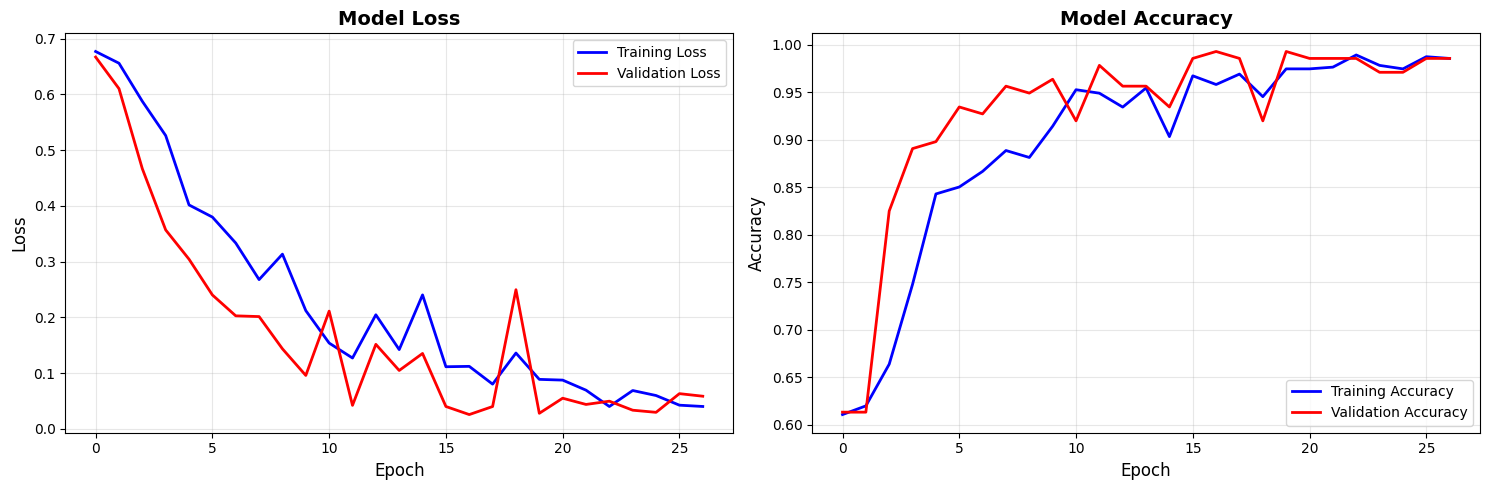


📈 TRAINING SUMMARY:
   Best Validation Accuracy: 0.9927 (Epoch 17)
   Final Training Accuracy: 0.9854
   Total Epochs: 27
✅ Model training completed successfully!


In [37]:
# Train model
if 'seq_model' in locals() and 'prepared_data' in locals():
    train_data = (X_train_features, X_train_masks, y_train)

    print("🎯 Starting training process...")
    history, trained_model = train_model_colab(seq_model, train_data)

    # Plot results
    plot_training_history_colab(history)

    print("✅ Model training completed successfully!")

else:
    print("⚠️  Skipping training - model or data not ready")

---

## 10. Model Evaluation

In [38]:
def evaluate_model(model, test_data, label_processor):
    """Evaluate model on test set"""

    X_test_features, X_test_masks, y_test = test_data

    print("Evaluating model on test set...")
    test_loss, test_accuracy = model.evaluate(
        [X_test_features, X_test_masks],
        y_test,
        verbose=1
    )

    print(f"\nTest Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

    # Get predictions
    predictions = model.predict([X_test_features, X_test_masks])
    predicted_classes = np.argmax(predictions, axis=1)

    # Classification report
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns

    class_names = label_processor.get_vocabulary()
    print(f"\nClassification Report:")
    print(classification_report(y_test, predicted_classes, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(DATASETS_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
    print(f"📊 Confusion matrix saved to Google Drive")
    plt.show()

    return test_accuracy, predictions

Evaluating model on test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0084

Test Results:
  Test Loss: 0.0089
  Test Accuracy: 1.0000 (100.00%)
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step

Classification Report:
                  precision    recall  f1-score   support

non shop lifters       1.00      1.00      1.00       106
    shop lifters       1.00      1.00      1.00        65

        accuracy                           1.00       171
       macro avg       1.00      1.00      1.00       171
    weighted avg       1.00      1.00      1.00       171

📊 Confusion matrix saved to Google Drive


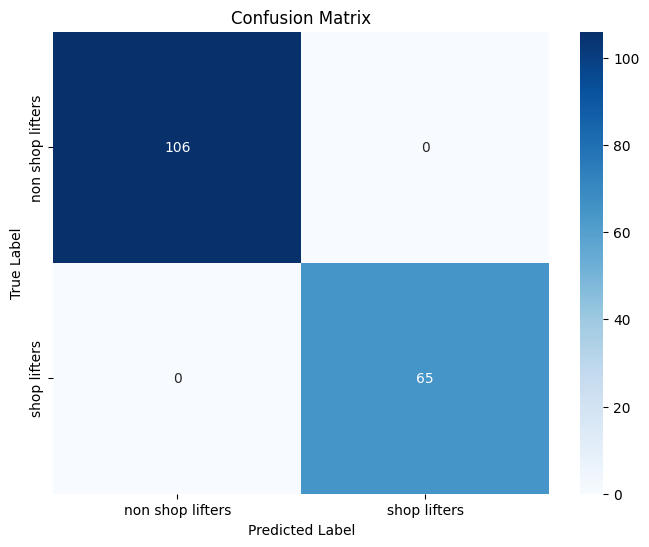

In [39]:
# Evaluate model
if 'trained_model' in locals() and 'prepared_data' in locals():
    test_data = (X_test_features, X_test_masks, y_test)
    test_accuracy, predictions = evaluate_model(trained_model, test_data, feature_data['label_processor'])

---

## 11. Save Final Model and Results

In [45]:
def save_model_and_results_to_drive():
    """Save the complete model and preprocessing components to Google Drive"""

    # Create results directory in Google Drive
    results_dir = os.path.join(DATASETS_DIR, "final_shoplifting_model")
    os.makedirs(results_dir, exist_ok=True)

    if 'trained_model' in globals():
        # Save the trained model
        model_path = os.path.join(results_dir, "shoplifting_detection_model.keras")
        trained_model.save(model_path)
        print(f"💾 Model saved to Google Drive: {model_path}")

        # Save preprocessing components
        preprocessing_path = os.path.join(results_dir, "preprocessing_components.pkl")
        preprocessing_components = {
            'label_processor': feature_data['label_processor'],
            'scaler': scaler,
            'img_size': IMG_SIZE,
            'max_seq_length': MAX_SEQ_LENGTH,
            'num_features': NUM_FEATURES,
            'batch_size': BATCH_SIZE,
            'feature_batch_size': FEATURE_BATCH_SIZE
        }

        with open(preprocessing_path, 'wb') as f:
            pickle.dump(preprocessing_components, f)
        print(f"🔧 Preprocessing components saved to Google Drive: {preprocessing_path}")

        # Save model summary as text
        with open(os.path.join(results_dir, "model_summary.txt"), 'w') as f:
            trained_model.summary(print_fn=lambda x: f.write(x + '\n'))

        # Create a comprehensive results summary
        results_summary = {
            'model_info': {
                'architecture': 'ResNet50 + GRU',
                'input_size': f"{IMG_SIZE}x{IMG_SIZE}",
                'max_sequence_length': MAX_SEQ_LENGTH,
                'feature_dimensions': NUM_FEATURES,
                'total_parameters': trained_model.count_params()
            },
            'dataset_info': {
                'total_videos': len(dataSet_df) if dataSet_df is not None else 0,
                'classes': feature_data['label_processor'].get_vocabulary() if 'feature_data' in locals() else [],
                'successful_extractions': feature_data.get('successful_videos', 0) if 'feature_data' in locals() else 0,
                'train_samples': len(X_train_features) if 'X_train_features' in locals() else 0,
                'test_samples': len(X_test_features) if 'X_test_features' in locals() else 0
            },
            'training_config': {
                'epochs_target': EPOCHS,
                'epochs_actual': len(history.history['loss']) if 'history' in locals() else 0,
                'batch_size': BATCH_SIZE,
                'feature_batch_size': FEATURE_BATCH_SIZE,
                'early_stopping': True,
                'learning_rate_reduction': True
            },
            'performance': {
                'test_accuracy': float(test_accuracy) if 'test_accuracy' in locals() else 'Not available',
                'best_val_accuracy': float(max(history.history['val_accuracy'])) if 'history' in locals() else 'Not available',
                'final_train_accuracy': float(history.history['accuracy'][-1]) if 'history' in locals() else 'Not available'
            },
            'colab_info': {
                'platform': 'Google Colab',
                'gpu_used': tf.test.gpu_device_name() if tf.test.gpu_device_name() else 'CPU only',
                'tensorflow_version': tf.__version__,
                'keras_version': keras.__version__
            }
        }

        import json
        with open(os.path.join(results_dir, "complete_results_summary.json"), 'w') as f:
            json.dump(results_summary, f, indent=2, default=str)

        # Create a README file for the model
        readme_content = f"""# Shoplifting Detection Model

                            ## Model Overview
                            - **Architecture**: ResNet50 (feature extraction) + GRU (sequence modeling)
                            - **Input**: Video sequences of {MAX_SEQ_LENGTH} frames at {IMG_SIZE}x{IMG_SIZE} resolution
                            - **Classes**: {', '.join(feature_data['label_processor'].get_vocabulary()) if 'feature_data' in locals() else 'N/A'}
                            - **Test Accuracy**: {test_accuracy:.2%} if 'test_accuracy' in locals() else 'N/A'

                            ## Files in this directory:
                            - `shoplifting_detection_model.keras`: Main trained model
                            - `preprocessing_components.pkl`: Scaler and label processor
                            - `complete_results_summary.json`: Detailed training and performance metrics
                            - `model_summary.txt`: Model architecture details
                            - `README.md`: This file

                            ## Usage:
                            Load the model using the code in Section 13 of the notebook.

                            ## Training Details:
                            - Trained on Google Colab
                            - Dataset: {len(dataSet_df)} videos ({feature_data.get('successful_videos', 0)} successfully processed)
                            - Training samples: {len(X_train_features) if 'X_train_features' in locals() else 'N/A'}
                            - Test samples: {len(X_test_features) if 'X_test_features' in locals() else 'N/A'}
                            - GPU: {tf.test.gpu_device_name() if tf.test.gpu_device_name() else 'CPU only'}

                            Generated automatically by the shoplifting detection notebook.
                            """

        with open(os.path.join(results_dir, "README.md"), 'w') as f:
            f.write(readme_content)

        print(f"📁 All files saved to Google Drive: {results_dir}")

        # Display final summary
        print("\n" + "="*60)
        print("🎉 MODEL TRAINING COMPLETE!")
        print("="*60)

        if 'test_accuracy' in locals():
            print(f"🎯 Final Test Accuracy: {test_accuracy:.2%}")
        if 'history' in locals():
            print(f"📈 Best Validation Accuracy: {max(history.history['val_accuracy']):.2%}")
            print(f"⏱️  Training Epochs: {len(history.history['loss'])}")

        print(f"💾 Model saved to: {results_dir}")
        print(f"🔗 Access your files at: Google Drive/Datasets/final_shoplifting_model/")
        print("="*60)

        return results_dir

    else:
        print("❌ No trained model found to save")
        return None

In [46]:
# Save everything to Google Drive
final_model_dir = save_model_and_results_to_drive()

💾 Model saved to Google Drive: /content/drive/MyDrive/Datasets/final_shoplifting_model/shoplifting_detection_model.keras
🔧 Preprocessing components saved to Google Drive: /content/drive/MyDrive/Datasets/final_shoplifting_model/preprocessing_components.pkl


📁 All files saved to Google Drive: /content/drive/MyDrive/Datasets/final_shoplifting_model

🎉 MODEL TRAINING COMPLETE!
💾 Model saved to: /content/drive/MyDrive/Datasets/final_shoplifting_model
🔗 Access your files at: Google Drive/Datasets/final_shoplifting_model/


In [47]:
if final_model_dir:
    print(f"\n📋 NEXT STEPS:")
    print("1. Download the model files from Google Drive if needed")
    print("2. Use Section 13 to test predictions on new videos")
    print("3. The model is ready for deployment or further fine-tuning")

    # Display Google Drive file tree
    print(f"\n📂 GOOGLE DRIVE FILE STRUCTURE:")
    try:
        for root, dirs, files in os.walk(DATASETS_DIR):
            level = root.replace(DATASETS_DIR, '').count(os.sep)
            indent = ' ' * 2 * level
            print(f"{indent}{os.path.basename(root)}/")
            subindent = ' ' * 2 * (level + 1)
            for file in files[:10]:  # Show first 10 files
                print(f"{subindent}{file}")
            if len(files) > 10:
                print(f"{subindent}... and {len(files)-10} more files")
    except:
        pass


📋 NEXT STEPS:
1. Download the model files from Google Drive if needed
2. Use Section 13 to test predictions on new videos
3. The model is ready for deployment or further fine-tuning

📂 GOOGLE DRIVE FILE STRUCTURE:
Datasets/
  Shop DataSet.zip
  dataset.csv
  extracted_features.pkl
  best_shoplifting_model.keras
  training_history.png
  confusion_matrix.png
  Extracted Data/
    Shop DataSet/
      non shop lifters/
        shop_lifter_n_0.mp4
        shop_lifter_n_0_1.mp4
        shop_lifter_n_1.mp4
        shop_lifter_n_1_1.mp4
        shop_lifter_n_10.mp4
        shop_lifter_n_10_1.mp4
        shop_lifter_n_100.mp4
        shop_lifter_n_100_1.mp4
        shop_lifter_n_101.mp4
        shop_lifter_n_101_1.mp4
        ... and 521 more files
      shop lifters/
        shop_lifter_0.mp4
        shop_lifter_1.mp4
        shop_lifter_10.mp4
        shop_lifter_100.mp4
        shop_lifter_101.mp4
        shop_lifter_102.mp4
        shop_lifter_103.mp4
        shop_lifter_104.mp4
        sh